# セグメンテーション

In [1]:
google_colab = False

# Google Colab用事前準備

In [2]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [3]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [4]:
device = 0

import binarybrain as bb

import importlib
importlib.reload(bb)
bb.omp_set_num_threads(4)
bb.set_device(device)
prop = bb.get_device_properties(device)
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [5]:
import binarybrain as bb
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [6]:
data_path = 'MnistSegDistillationTest3Rtl'
network_name = 'mnist-seg-distillation-test3'

In [7]:
def make_test_image(src_x, src_t):
    dst_x = np.ndarray((len(src_x),  1, 28, 28), dtype=np.float32)
    dst_t = np.ndarray((len(src_x), 11, 28, 28), dtype=np.float32)
    for i in range(len(src_x)):
        x_img = src_x[i].copy()
        t_img = np.zeros((11, 28*28), dtype=np.float32)
        mask0 = x_img <= 0.5
        mask1 = x_img > 0.5
        for j in range(10):
          t_img[j,mask1] = src_t[i][j]
        t_img[10,mask0] = 0.15
        dst_x[i] = x_img.reshape(1, 28, 28)
        dst_t[i] = t_img.reshape(11, 28, 28)
    return dst_x, dst_t

def make_test_data(src_x, src_t):
    x, t = make_test_image(src_x, src_t)

    dst_x = np.ndarray((len(src_x) // 4,  1*56*56), dtype=np.float32)
    dst_t = np.ndarray((len(src_x) // 4, 11*56*56), dtype=np.float32)
    for i in range(len(x) // 4):
        x_img = np.hstack((np.dstack((x[i*4+0], x[i*4+1])), np.dstack((x[i*4+2], x[i*4+3]))))
        t_img = np.hstack((np.dstack((t[i*4+0], t[i*4+1])), np.dstack((t[i*4+2], t[i*4+3]))))
        dst_x[i] = x_img.reshape(-1)
        dst_t[i] = t_img.reshape(-1)
    return dst_x, dst_t

def image_transform(img):
    angle = random.uniform(-10.0, +10.0)
    scale = random.uniform(0.8, 1.1)
    trans = cv2.getRotationMatrix2D((14, 14), angle , scale)
    trans[0][2] += random.uniform(-2.0, 2.0)
    trans[1][2] += random.uniform(-2.0, 2.0)
    return cv2.warpAffine(img.reshape(28, 28), trans, (28, 28))

def make_td_image(src_x, src_t, w=28, h=28, depth=27):
    l = len(src_x)
    mx = (28 + depth + w + depth + 27) // 28
    my = (28 + depth + h + depth + 27) // 28
    dst_x = np.zeros(( 1, 28*my, 28*mx), dtype=np.float32)
    dst_t = np.zeros((11, 28*my, 28*mx), dtype=np.float32)
    for y in range(my):
        for x in range(mx):
            i = random.randrange(0, l)
            dst_x[0,y*28:y*28+28, x*28:x*28+28] = image_transform(src_x[i])
            dst_t[0:10,y*28:y*28+28, x*28:x*28+28] = np.tile(src_t[i], (28,28)).reshape(28, 28, 10).transpose(2, 0, 1)
    x_flag0 = dst_x[0] <= 0.5
    x_flag1 = dst_x[0] >  0.5
    for i in range(10):
        dst_t[i][x_flag0] = 0
    dst_t[10][x_flag0] = 0.15  # ここ重要
    
    xs = random.randrange(0, 28)
    ys = random.randrange(0, 28)
    dst_x  = dst_x[:,ys:ys+2*depth+h,xs:xs+2*depth+w]
    x_flag = x_flag1[ys:ys+2*depth+h,xs:xs+2*depth+w]
    
    dst_t  = dst_t[:,ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    t_flag = x_flag1[ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    
    x_mask = np.zeros(x_flag.shape, dtype=np.float32)
    x_mask[x_flag] = 1.0
    t_mask = np.zeros(t_flag.shape, dtype=np.float32)
    t_mask[t_flag] = 1.0
    return dst_x.flatten(), dst_t.flatten(), x_mask.flatten(), t_mask.flatten()

def generate_td(src_td, train_size=5000//2, test_size=1000//2, w=28, h=28, depth=27):
    dst_td = {}
    
    dst_td['x_train']      = []
    dst_td['t_train']      = []
    dst_td['x_mask_train'] = []
    dst_td['t_mask_train'] = []
    for _ in tqdm(range(train_size)):
        x, t, xm, tm = make_td_image(src_td['x_train'], src_td['t_train'], w=w, h=h, depth=depth)
        dst_td['x_train'].append(x)
        dst_td['t_train'].append(t)
        dst_td['x_mask_train'].append(xm)
        dst_td['t_mask_train'].append(tm)
    dst_td['x_train']      = np.array(dst_td['x_train'])
    dst_td['t_train']      = np.array(dst_td['t_train'])
    dst_td['x_mask_train'] = np.array(dst_td['x_mask_train'])
    dst_td['t_mask_train'] = np.array(dst_td['t_mask_train'])
    
    dst_td['x_test']      = []
    dst_td['t_test']      = []
    dst_td['x_mask_test'] = []
    dst_td['t_mask_test'] = []
    for _ in tqdm(range(test_size)):
        x, t, xm, tm = make_td_image(src_td['x_test'], src_td['t_test'], w=w, h=h, depth=depth)
        dst_td['x_test'].append(x)
        dst_td['t_test'].append(t)
        dst_td['x_mask_test'].append(xm)
        dst_td['t_mask_test'].append(tm)
    dst_td['x_test']      = np.array(dst_td['x_test'])
    dst_td['t_test']      = np.array(dst_td['t_test'])
    dst_td['x_mask_test'] = np.array(dst_td['x_mask_test'])
    dst_td['t_mask_test'] = np.array(dst_td['t_mask_test'])
    
    dst_td['x_shape'] = [depth*2+w, depth*2+h, 1]
    dst_td['t_shape'] = [w, h, 11]
    
    return dst_td

In [8]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = color_table[idx_img[y][x]]
    return rgb_img

In [9]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    data = y_buf.get_data(0)
    
    plt.subplot(141)
    frame = np.array(data[0]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))
    
    plt.subplot(142)
    frame = np.array(data[1]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.subplot(143)
    frame = np.array(data[2]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.subplot(144)
    frame = np.array(data[3]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.show()

In [10]:
# load MNIST data
src_td = bb.load_mnist()

In [11]:
# 設定
layer_depth = 27
t_width     = 28*2
t_height    = 28*2

In [12]:
td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 532.39it/s]


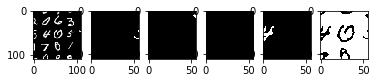

In [13]:
plt.subplot(161)
plt.imshow(td['x_train'][0].reshape(layer_depth*2+56, layer_depth*2+56), 'gray')
plt.subplot(162)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[5], 'gray')
plt.subplot(163)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[3], 'gray')
plt.subplot(164)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[9], 'gray')
plt.subplot(165)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[4], 'gray')
plt.subplot(166)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[10], 'gray')

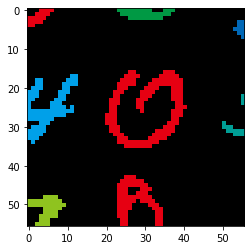

In [14]:
plt.imshow(frame_to_image(td['t_train'][0].reshape(11, 56, 56)))

# ネットワーク構築

## 蒸留用クラス

In [15]:
def lut_sort(lut, order):
    group_size  = order.shape[0]
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()
    input_unit  = input_size // group_size
    output_unit = output_size // group_size
    for g in range(group_size):
        for o in range(output_unit):
            node = g * output_unit + o
            for i in range(lut.get_node_connection_size(node)):
                idx = o*6 + i
                if idx < order.shape[1]:
                    lut.set_node_connection_index(node, i, order[g][idx])

def lut_set_serial(lut):
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()
    for n in range(output_size):
        for i in range(lut.get_node_connection_size(n)):
            idx = (n*6+i) % input_size
            lut.set_node_connection_index(n, i, idx)
            
class DistillationLayer:
    def __init__(self, layer_name):
        self.layer_name = layer_name
        
    def get_model(self):
        return self.model
    
    def switch_model(self, name):
        return False

    def setup_distillation(self):
        return False
    
    def convert_binlut(self):
        return False

    def save(self, path):
        pass
    
    def load(self, path):
        pass

    def save_model(self, model, name, path):
        os.makedirs(os.path.join(data_path, path, self.layer_name), exist_ok=True)
        filename = os.path.join(data_path, path, self.layer_name, '%s.json' % name)
#       print('[save] %s' % filename)
        model.save_json(filename)

    def load_model(self, model, name, path):
        filename = os.path.join(data_path, path, self.layer_name, '%s.json' % name)
        if not os.path.exists(filename):
#           print('[load error] %s' % filename)            
            return False
#       print('[load] %s' % filename)
        model.load_json(filename)
        return True
    
    
class CommonLayer(DistillationLayer):
    def __init__(self, layer_name, model, storable=False, store_name='model'):
        super(CommonLayer, self).__init__(layer_name)      
        self.model      = model
        self.storable   = storable
        self.store_name = store_name
        
    def save(self, path):
        if self.storable:
            self.save_model(self.model, path)
    
    def load(self, path):
        if self.storable:
            return self.load_model(self.model, path)
        return True

    
class ConvLayer(DistillationLayer):
    def __init__(self, layer_name, ch_size, w=3, h=3, lut_size=2, batch_norm=True, padding='valid'):
        super(ConvLayer, self).__init__(layer_name)
        
        self.distillation_flag = False
        
        # reference model
        self.affine     = bb.DenseAffine.create([ch_size])
        if batch_norm:
            self.batch_norm = bb.BatchNormalization.create()
        else:
            self.batch_norm = None
        self.activation = bb.BinarizeBit.create()
        self.ref_subnet =  bb.Sequential.create()
        self.ref_subnet.add(self.affine)
        if batch_norm:
            self.ref_subnet.add(self.batch_norm)
        self.ref_subnet.add(self.activation)
        self.ref_model = bb.LoweringConvolutionBit.create(self.ref_subnet, w, h, 1, 1, padding=padding)
        
        # target 
        self.lut_list = []
        for i in range(lut_size):
            lut = bb.SparseLut6Bit.create([ch_size*(6**i)], batch_norm=batch_norm, connection='serial')
            self.lut_list.append(lut)
        
        self.target_subnet =  bb.Sequential.create()
        for lut in (reversed(self.lut_list)):
            self.target_subnet.add(lut)
        self.target_model = bb.LoweringConvolutionBit.create(self.target_subnet, w, h, 1, 1, padding=padding)
        
        # BinaryLUT
        self.binlut_list = []
        for i in range(lut_size):
            binlut = bb.BinaryLut6Bit.create([ch_size*(6**i)])
            self.binlut_list.append(binlut)
        self.binlut_subnet =  bb.Sequential.create()
        for binlut in (reversed(self.binlut_list)):
            self.binlut_subnet.add(binlut)            
        self.binlut_model = bb.LoweringConvolutionBit.create(self.binlut_subnet, w, h, 1, 1, padding=padding)
        
        self.model = self.ref_model
    
    def switch_model(self, name):
        if name == 'target':
            self.model = self.target_model
            self.distillation_flag = True
            return True
        elif name == 'reference':
            self.model = self.ref_model
            self.distillation_flag = False
            return True
        elif name == 'binlut':
            self.model = self.binlut_model            
        return False
            
    def setup_distillation(self):
        tensorW = self.affine.W()
        W = np.array(tensorW.get_data()).reshape(tensorW.get_shape()[::-1])
        order = np.argsort(-np.abs(W), axis=1)
        
        self.target_model.set_input_shape(self.ref_model.get_input_shape())
        
        for i, lut in enumerate(self.lut_list):
            if i < len(self.lut_list) - 1:
                lut_set_serial(lut)
            else:
                lut_sort(lut, order)
        
        self.model = self.target_model
        self.distillation_flag = True
        return True
    
    def convert_binlut(self):
        self.binlut_model.set_input_shape(self.target_model.get_input_shape())
        for i in range(len(self.lut_list)):
            self.binlut_list[i].import_parameter(self.lut_list[i])
        self.model = self.binlut_model
        return True
        
    def save(self, path):
        self.save_model(self.affine,     'affine',     path)
        if self.batch_norm is not None:
            self.save_model(self.batch_norm, 'batch_norm', path)
        if self.distillation_flag:
            for i, lut in enumerate(self.lut_list):
                self.save_model(lut, 'sparse_lut_%d' % i, path)
    
    def load(self, path):
        loaded = True
        loaded = self.load_model(self.affine,     'affine',     path) and loaded
        if self.batch_norm is not None:
            loaded = self.load_model(self.batch_norm, 'batch_norm', path) and loaded
        if not loaded:
            return False
        self.model = self.ref_model
        
        if self.distillation_flag:
            self.target_model.set_input_shape(self.ref_model.get_input_shape())
            
            loaded = True
            for i, lut in enumerate(self.lut_list):
                loaded = self.load_model(lut, 'sparse_lut_%d' % i, path) and loaded
            if not loaded:
                return False
            
            self.model = self.target_model
        
        return loaded

class PointwiseConvLayer(ConvLayer):
    def __init__(self, layer_name, ch_size, lut_size=2, batch_norm=True, padding='valid'):
        super(PointwiseConvLayer, self).__init__(layer_name, ch_size, w=1, h=1, lut_size=lut_size, batch_norm=batch_norm, padding=padding)

class DepthwiseConvLayer(DistillationLayer):
    def __init__(self, layer_name, out_shape, w=3, h=3, lut_size=2, batch_norm=True, connection='random', padding='valid'):
        super(DepthwiseConvLayer, self).__init__(layer_name)
        self.lut_depthwise = bb.SparseLut6Bit.create(out_shape, batch_norm=batch_norm, connection='depthwise')
        self.subnet =  bb.Sequential.create()
        self.subnet.add(self.lut_depthwise)
        self.target_model = bb.LoweringConvolutionBit.create(self.subnet, w, h, 1, 1, padding=padding)
        self.model = self.target_model
        
        self.binlut_depthwise = bb.BinaryLut6Bit.create(out_shape)
        self.binlut_subnet =  bb.Sequential.create()
        self.binlut_subnet.add(self.binlut_depthwise)
        self.binlut_model = bb.LoweringConvolutionBit.create(self.binlut_subnet, w, h, 1, 1, padding=padding)

    def convert_binlut(self):
        self.binlut_model.set_input_shape(self.target_model.get_input_shape())
        self.binlut_depthwise.import_parameter(self.lut_depthwise)
        self.model = self.binlut_model
        return True

    def save(self, path):
        self.save_model(self.lut_depthwise, 'sparse_lut', path)
        
    def load(self, path):
        return self.load_model(self.lut_depthwise, 'sparse_lut', path)

In [16]:
def build_network(layer_list):
    net = bb.Sequential.create()
    for layer in layer_list:
        net.add(layer.get_model())
    return net

def save_layers(layer_list, path):
    for layer in layer_list:
        layer.save(path)

def load_layers(layer_list, path):
    loaded = True
    for layer in layer_list:
        loaded = layer.load(path) and loaded
    return loaded

In [17]:
print(td['t_shape'])

[56, 56, 11]


In [18]:
# build network
layer_rel2bin = bb.RealToBinaryBit.create(3, framewise=True)
layer_bin2rel = bb.BinaryToRealBit.create(3)

idx = 0

layer_list = []
layer_list.append(CommonLayer('rel2bin', layer_rel2bin))

layer_list.append(DepthwiseConvLayer('depthwise_cnv%d' % idx, [32, 1, 1], 3, 3))  # 26x26
layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 32, lut_size=2))
idx += 1

for i in range(25):
    layer_list.append(DepthwiseConvLayer('depthwise_cnv%d' % idx, [8, 1, 32], 3, 3)) # 24x24
    layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 32, lut_size=2))
    idx += 1
   
layer_list.append(DepthwiseConvLayer('depthwise_cnv%d' % idx, [8, 1, 32], 3, 3))# 1x1
layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 64, lut_size=2))
idx += 1

layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 36, lut_size=2))
idx += 1

layer_list.append(PointwiseConvLayer('pointwise_cnv%d' % idx, 11, lut_size=2, batch_norm=False))
idx += 1

layer_list.append(CommonLayer('bin2rel', layer_bin2rel))

net = build_network(layer_list)
net.set_input_shape(td['x_shape'])

[56, 56, 11]

In [19]:
td['x_shape']

[110, 110, 1]

In [20]:
# 初回から全部LUTにしてしまう場合
if True:
    for layer in layer_list:
        layer.switch_model('target')
    net = build_network(layer_list)
    net.set_input_shape(td['x_shape'])

In [21]:
print(net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output

In [22]:
net.send_command('binary true')
        
loss    = bb.LossSoftmaxCrossEntropy.create()
metrics = bb.MetricsCategoricalAccuracy.create()

#loaded = load_layers(layer_list, 'last2_0')
loaded = load_layers(layer_list, 'fine_4')
print(loaded)

True


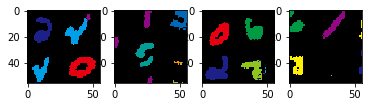

In [23]:
plot_image(net, td)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 478.44it/s]


epoch=1 test_accuracy=0.397461 test_loss=4966.761496 train_accuracy=0.391176 train_loss=4967.128632


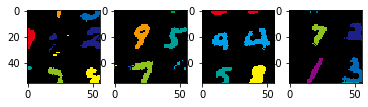

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 417.15it/s]


epoch=1 test_accuracy=0.392089 test_loss=4969.416004 train_accuracy=0.382470 train_loss=4971.111396


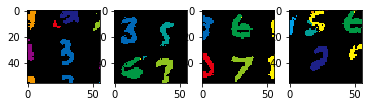

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 384.13it/s]


epoch=1 test_accuracy=0.387782 test_loss=4970.427247 train_accuracy=0.385176 train_loss=4970.328360


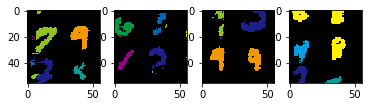

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 349.03it/s]


epoch=1 test_accuracy=0.400515 test_loss=4977.807368 train_accuracy=0.392746 train_loss=4977.802954


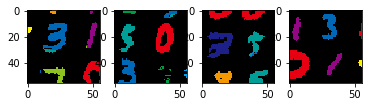

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 351.73it/s]


epoch=1 test_accuracy=0.054655 test_loss=5440.634348 train_accuracy=0.055612 train_loss=5436.288578


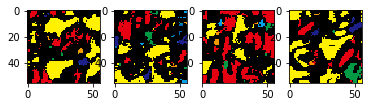

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 402.51it/s]


epoch=1 test_accuracy=0.400041 test_loss=4959.859116 train_accuracy=0.391847 train_loss=4961.664167


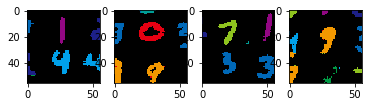

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 506.75it/s]


epoch=1 test_accuracy=0.103272 test_loss=5283.594214 train_accuracy=0.099983 train_loss=5282.902141


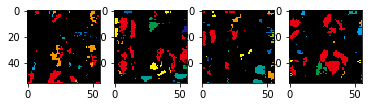

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 428.72it/s]


epoch=1 test_accuracy=0.401503 test_loss=4968.283730 train_accuracy=0.395039 train_loss=4968.232279


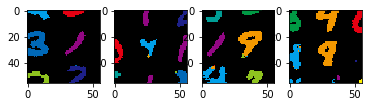

In [24]:
# modulation無しで追加学習
if True:
    net.send_command('parameter_lock false')
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(net.get_parameters(), net.get_gradients())
    runner = bb.Runner(net, network_name, loss, metrics, optimizer)
    for i in range(8, 16):
        td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)
        runner.fitting(td, epoch_size=1, mini_batch_size=8, file_write=False, file_read=False)
        plot_image(net, td)
        save_layers(layer_list, 'fine')
        save_layers(layer_list, 'fine_%d' % i)

# verilog化する

In [25]:
for layer in layer_list:
    layer.convert_binlut()
net = build_network(layer_list)
net.set_input_shape(td['x_shape'])
print(net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [BinaryLutN] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output shape : {108, 108, 32}
  -------------

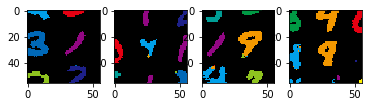

In [26]:
plot_image(net, td)

In [27]:
cnv_list = []
for layer in layer_list:
    if 'cnv' in layer.layer_name:
#       print(layer.layer_name)
        cnv_list.append(layer.binlut_model)
rtl_text = bb.make_verilog_axi4s_from_lut_cnn_bit('mnist_seg', cnv_list)

In [28]:
with open('mnist_seg.v', 'w') as f:
    f.write(rtl_text)

## グラフ描画してみる

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def print_layer_graph(lut):
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()

    G = nx.Graph()
    for i in range(input_size):
        G.add_node('in%d' % i)
    for o in range(output_size):
        G.add_node('out%d' % o)

    for o in range(output_size):
        for l in range(6):
            i = lut.get_node_connection_index(o, l)
            G.add_edge('in%d' % i, 'out%d' % o)

    pos = {}
    in_space  = 1 / (input_size + 1)
    for i in range(input_size):
        pos['in%d' % i] = (0, (i+1)*in_space)
    out_space = 1 / (output_size + 1)
    for o in range(output_size):
        pos['out%d' % o] = (1, (o+1)*out_space)

    nx.draw_networkx(G, pos=pos, node_color="c")
    plt.show()

In [30]:
#plt.figure(figsize=(16, 16))
#print_layer_graph(layer_list[16].lut_list[1])